In [1]:
!git clone 'https://github.com/LuchnikovI/ML-meets-quantum-physics-QIT-lab-seminar'
%cd 'ML-meets-quantum-physics-QIT-lab-seminar/Seminar 1, Recurrent Neural Network Wave Functions'

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from rnn_wavefunction import RNNWaveFunction as psi

Cloning into 'ML-meets-quantum-physics-QIT-lab-seminar'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (12/12), done.
/content/ML-meets-quantum-physics-QIT-lab-seminar/Seminar 1, Recurrent Neural Network Wave Functions


In [ ]:
@tf.function
def double_flip_sample(samples, ind):
    sort_ind = tf.sort(ind)
    sample1 = tf.roll(samples[:, sort_ind[0]], axis=-1, shift=1)
    sample2 = tf.roll(samples[:, sort_ind[1]], axis=-1, shift=1)
    flipped_samples = tf.concat([samples[:, :sort_ind[0]],
                                 sample1[:, tf.newaxis],
                                 samples[:, sort_ind[0] + 1:sort_ind[1]],
                                 sample2[:, tf.newaxis],
                                 samples[:, sort_ind[1] + 1:]], axis=1)
    return flipped_samples

@tf.function
def single_flip_sample(samples, ind):
    sample = tf.roll(samples[:, ind], axis=-1, shift=1)
    flipped_samples = tf.concat([samples[:, :ind],
                                 sample[:, tf.newaxis],
                                 samples[:, ind + 1:]], axis=1)
    return flipped_samples


class RNNWaveFunction:

    def __init__(self, rnn_cell, ffnn,
                 number_of_particles, local_dim):
        
        self.cell = rnn_cell  # rnn cell or list of cells
        self.nn = ffnn  # neural network that processes output of rnn
        self.N = number_of_particles  # number of particles
        self.n = local_dim  # dimension of local Hilbert space
        self.state_size = rnn_cell.state_size  # size of hidden state

        # full NN that prcoesses samples
        inp = tf.keras.Input((number_of_particles, local_dim))
        in_state = tf.keras.Input((self.state_size,))
        rnn_out = tf.keras.layers.RNN(rnn_cell, return_sequences=True,)(inp, initial_state=in_state)
        nn_out = ffnn(rnn_out)
        nn_out_resh = tf.keras.layers.Reshape((self.N, self.n, 2))(nn_out)
        logits = nn_out_resh[..., 0]
        phase = nn_out_resh[..., 1]
        log_p = tf.keras.layers.Lambda(lambda x: tf.nn.log_softmax(x, axis=-1))(logits)
        phi = pi * tf.keras.activations.softsign(phase)
        self.rnn = tf.keras.Model(inputs=[inp, in_state], outputs=[log_p, phi])

    @tf.function
    def sample(self, number_of_samples):

        # initial state
        in_state = tf.ones((number_of_samples, self.state_size))
        # initial samples tensor
        samples = tf.ones((number_of_samples, 1, self.n))
        # initial number of iteration
        i = tf.constant(0)
        # body of a loop
        def sample_one_side(i, state, samples):
            # Apply rnn cell to previous sample and state, output shape
            # (number_of_samples, self.state_size)
            cell_out, _ = self.cell(inputs=samples[:, -1], states=state)
            # apply NN to output of rnn cell, output shape
            # (number_of_samples, 2 * self.n)
            nn_out = self.nn(cell_out)
            # reshape of NN output, output shape 
            # (number_of_samples, self.n, 2)
            nn_out_resh = tf.reshape(nn_out, (number_of_samples, self.n, 2))
            # generate sampe, output shape (number_of_samples, self.n)
            logits = nn_out_resh[..., 0]
            log_p = tf.nn.log_softmax(logits, axis=-1)
            eps = tf.random.uniform(log_p.shape)
            eps = -tf.math.log(-tf.math.log(eps))
            s = tf.one_hot(tf.argmax(log_p + eps, axis=-1), axis=-1, depth=self.n)
            # add generated sample to samples
            s = s[:, tf.newaxis]
            new_samples = tf.concat([samples, s], axis=1)

            return i+1, cell_out, new_samples
        # condition
        cond = lambda i, state, samples: i < self.N

        _, _, samples = tf.while_loop(cond,
                                      sample_one_side,
                                      loop_vars=[i, in_state, samples],
                                      shape_invariants=[i.get_shape(),
                                                        in_state.get_shape(),
                                                        tf.TensorShape((number_of_samples, None, self.n))])
        return samples[:, 1:]

    @tf.function
    def value(self, samples):
        dtype = samples.dtype
        # initial state
        state = tf.ones((samples.shape[0], self.state_size))
        s0 = tf.ones((samples.shape[0], 1, self.n))
        log_p, phi = self.rnn([tf.concat([s0, samples[:, :-1]], axis=1), state])
        log_p = tf.reduce_sum(log_p * samples, axis=(-2, -1))
        phi = tf.reduce_sum(phi * samples, axis=(-2, -1))
        return log_p, phi

    @tf.function
    def local_energy(self,
                     connections,
                     ampls,
                     local_fields,
                     samples):
        
        log_p, phi = self.value(samples)
        log_p = tf.cast(log_p, dtype=tf.complex64)
        phi = tf.cast(phi, dtype=tf.complex64)
        csamples = tf.cast(samples, dtype=tf.complex64)

        x = tf.constant([1, 1], dtype=tf.complex64)
        y = tf.constant([-1j, 1j], dtype=tf.complex64)
        z = tf.constant([1, -1], dtype=tf.complex64)

        E = tf.zeros((samples.shape[0],), dtype=tf.complex64)
        iter = tf.constant(0)

        def local_int_term(iter, E):

            ind = connections[iter]
            # xx energy
            Exx = tf.reduce_sum(csamples[:, ind[0]] * x, axis=-1) *\
            tf.reduce_sum(csamples[:, ind[1]] * x, axis=-1)
            Exx = Exx * ampls[iter, 0]
            # yy energy
            Eyy = tf.reduce_sum(csamples[:, ind[0]] * y, axis=-1) *\
            tf.reduce_sum(csamples[:, ind[1]] * y, axis=-1)
            Eyy = Eyy * ampls[iter, 1]
            # zz energy
            Ezz = tf.reduce_sum(csamples[:, ind[0]] * z, axis=-1) *\
            tf.reduce_sum(csamples[:, ind[1]] * z, axis=-1)
            Ezz = Ezz * ampls[iter, 2]

            double_flipped_samples = double_flip_sample(samples, ind)
            double_flipped_log_p, double_flipped_phi = self.value(double_flipped_samples)
            double_flipped_log_p = tf.cast(double_flipped_log_p, dtype=tf.complex64)
            double_flipped_phi = tf.cast(double_flipped_phi, dtype=tf.complex64)
            ratio = tf.exp(0.5 * double_flipped_log_p -\
                           0.5 * log_p +\
                           1j * double_flipped_phi -\
                           1j * phi)
            E_new = Exx * ratio + Eyy * ratio + Ezz
            return iter + 1, E_new + E

        cond1 = lambda iter, E: iter < connections.shape[0]
        _, E = tf.while_loop(cond1, local_int_term, loop_vars=[iter, E])

        def local_term(iter, E):
            # x energy
            Ex = tf.reduce_sum(csamples[:, iter] * x, axis=-1)
            Ex = Ex * local_fields[iter, 0]
            # y energy
            Ey = tf.reduce_sum(csamples[:, iter] * x, axis=-1)
            Ey = Ey * local_fields[iter, 1]
            # z energy
            Ez = tf.reduce_sum(csamples[:, iter] * x, axis=-1)
            Ez = Ez * local_fields[iter, 2]

            single_flipped_sample = single_flip_sample(samples, iter)
            single_flipped_log_p, single_flipped_phi = self.value(single_flipped_sample)
            single_flipped_log_p = tf.cast(single_flipped_log_p, dtype=tf.complex64)
            single_flipped_phi = tf.cast(single_flipped_phi, dtype=tf.complex64)
            ratio = tf.exp(0.5 * single_flipped_log_p -\
                           0.5 * log_p +\
                           1j * single_flipped_phi -\
                           1j * phi)
            E_new = Ex * ratio + Ey * ratio + Ez
            return iter + 1, E_new + E

        cond2 = lambda iter, E: iter < self.N
        _, E = tf.while_loop(cond2, local_term, loop_vars=[iter, E])
        return E

In [ ]:
num_of_particels = 32
cell = tf.keras.layers.GRUCell(64)
#--------------------------#
inp = tf.keras.Input((64,))
#h = tf.keras.layers.Dense(128, activation='elu')(inp)
out = tf.keras.layers.Dense(4)(inp)
ffnn = tf.keras.Model(inputs=inp, outputs=out)
#---------------------------#
psi = RNNWaveFunction(cell, ffnn, num_of_particels, 2)

# connections
c = tf.range(num_of_particels)[:, tf.newaxis]
c = tf.concat([c, tf.roll(c, axis=0, shift=1)], axis=1)

lr = 0.003

opt = tf.optimizers.Adam(lr)

# amplitudes of connections
ampl = tf.concat([tf.zeros((num_of_particels, 2), dtype=tf.complex64),
                  tf.ones((num_of_particels, 1), dtype=tf.complex64)], axis=-1)

# local fields
fields = tf.concat([tf.ones((num_of_particels, 1), dtype=tf.complex64),
                  tf.zeros((num_of_particels, 2), dtype=tf.complex64)], axis=-1)

av_E = tf.constant(0, dtype=tf.complex64)


E_list = []
for _ in tqdm(range(4000)):
    with tf.GradientTape() as tape:
        samples = tf.stop_gradient(psi.sample(1024))
        local_E = tf.stop_gradient(psi.local_energy(c, ampl, fields, samples))
        log_p, phi = psi.value(samples)
        log_p = tf.cast(log_p, dtype=tf.complex64)
        phi = tf.cast(phi, dtype=tf.complex64)
        log_psi_conj = 0.5 * log_p - 1j * phi
        loss = 2 * tf.math.real(tf.reduce_mean(log_psi_conj * (local_E - av_E)))
    av_E = tf.reduce_mean(local_E)
    E_list.append(av_E)
    grad = tape.gradient(loss, ffnn.weights + cell.weights)
    opt.apply_gradients(zip(grad, ffnn.weights + cell.weights))




  0%|          | 0/4000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

 16%|█▌        | 626/4000 [12:38<1:07:05,  1.19s/it]


 16%|█▌        | 627/4000 [12:39<1:07:15,  1.20s/it]


 16%|█▌        | 628/4000 [12:40<1:07:14,  1.20s/it]


 16%|█▌        | 629/4000 [12:41<1:06:58,  1.19s/it]


 16%|█▌        | 630/4000 [12:42<1:06:43,  1.19s/it]


 16%|█▌        | 631/4000 [12:44<1:07:01,  1.19s/it]


 16%|█▌        | 632/4000 [12:45<1:06:39,  1.19s/it]


 16%|█▌        | 633/4000 [12:46<1:06:56,  1.19s/it]


 16%|█▌        | 634/4000 [12:47<1:07:00,  1.19s/it]


 16%|█▌        | 635/4000 [12:48<1:06:37,  1.19s/it]


 16%|█▌        | 636/4000 [12:50<1:06:15,  1.18s/it]


 16%|█▌        | 637/4000 [12:51<1:06:17,  1.18s/it]


 16%|█▌        | 638/4000 [12:52<1:05:52,  1.18s/it]


 16%|█▌        | 639/4000 [12:53<1:05:57,  1.18s/it]


 16%|█▌        | 640/4000 [12:54<1:06:06,  1.18s/it]


 16%|█▌        | 641/4000 [12:55<1:05:35,  1.17s/it]


 16%|█▌        | 642/4000 [12:57<1:05:42,  1.17s/it]


 16%|█▌      

KeyboardInterrupt: ignored

In [ ]:

# exact value of energy in the critical point
E0_exact_fin = -2 * (1 / np.sin(np.pi / (2 * num_of_particels))) / num_of_particels # exact energy
E0_exact_fin

-1.273751015443507

In [ ]:
av_E / num_of_particels

<tf.Tensor: shape=(), dtype=complex64, numpy=(-1.2710869-6.8056593e-06j)>

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


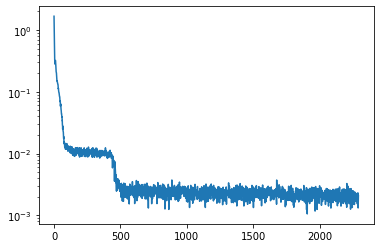

In [ ]:
plt.plot((tf.convert_to_tensor(E_list) / 32 - E0_exact_fin) / -E0_exact_fin)
plt.yscale('log')

In [ ]:
samples = tf.stop_gradient(psi.sample(10000))

In [ ]:
corrs = []
for i in range(1, num_of_particels):
    local_corr = psi.local_energy(tf.constant([[0, i]]),
                                tf.constant([[0, 1, 0]], dtype=tf.complex64),
                                tf.zeros((num_of_particels, 3), dtype=tf.complex64),
                                samples)
    corr = tf.reduce_mean(local_corr)
    corrs.append(corr)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


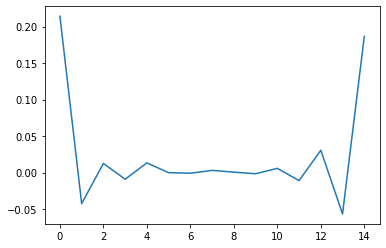

In [ ]:
plt.plot(corrs)